In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

####Importing iris dataset

In [2]:
path='/home/sadat/Documents/DSE/Data/Final_210/iris.data.txt'
df = pd.read_csv(path, names=['sepal length','sepal width','petal length','petal width','class'])
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


####Perform PCA decomposition to 2 components

In [3]:
pca = PCA(n_components=2)
pca.fit(df.ix[:,0:4].values)
X = pca.transform(df.ix[:,0:4].values)

In [4]:
df['V0']=X[:,0]
df['V1']=X[:,1]
df.head()

,sepal length,sepal width,petal length,petal width,class,V0,V1
0,5.1,3.5,1.4,0.2,Iris-setosa,-2.684207,-0.326607
1,4.9,3.0,1.4,0.2,Iris-setosa,-2.715391,0.169557
2,4.7,3.2,1.3,0.2,Iris-setosa,-2.889820,0.137346
3,4.6,3.1,1.5,0.2,Iris-setosa,-2.746437,0.311124
4,5.0,3.6,1.4,0.2,Iris-setosa,-2.728593,-0.333925


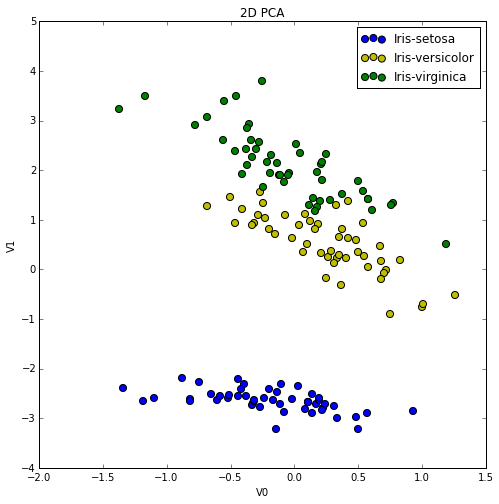

In [5]:
classes = df['class'].unique()
color=['b','y','g']
plt.figure(figsize=(8,8))
plt.xlabel('V0')
plt.ylabel('V1')
plt.title('2D PCA')
for cl, co in zip(classes,color):
    V0 = df[df['class']==cl]['V0'].values
    V1 = df[df['class']==cl]['V1'].values
    plt.scatter(V1,V0, c=co, s=50)
plt.legend(classes)

We can see that iris-virginica is well separated. 

There is some overlap between iris-sentosa and iris-virginica.

Based on the 2D plot, separating iris-sentosa and iris-virginica with our classifier would be a challenge.

####Estimating a classifier

Since we have an equal number of each class, we will not use $\pi$ in our classifier.

Generating the training and test datasets:

In [6]:
#training dataset
df_train = df[df['class']==classes[0]][0:35]
for c in classes[1::]:
    df_train = pd.concat([df_train, df[df['class']==c][0:35]])

#test dataset
df_test = df[df['class']==classes[0]][35::]
for c in classes[1::]:
    df_test = pd.concat([df_test, df[df['class']==c][35::]])

For our classifier, we will use a Multivariate Gaussian.

As all the classes are of the same size, we will not incorporate $\pi$ into the equation

$$X \sim N_{4}(\mu,\Sigma)$$

In [26]:
def classify(sample_df, valid_df, smooth):

    #Empty list for probabilities
    prob = []

    #Find probability of each classifier
    for label in range(3): 
        cond = sample_df['class']==classes[label]
        mean = np.mean(sample_df.ix[:,0:4].values, axis = 0)
        cov = np.cov(np.transpose(sample_df[cond].ix[:,0:4].values)) + (smooth*np.identity(4))
        func = multivariate_normal(mean, cov)
        prob.append(func.logpdf(valid_df.ix[:,0:4]))

    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)

    #Compare with valid target to get error
    error = np.sum([classes[i]!=j for i,j in zip(max_prob, valid_df['class'])])/len(valid_df)
    return error

We try to train the dataset and test it against itsef to optimize smoothing.

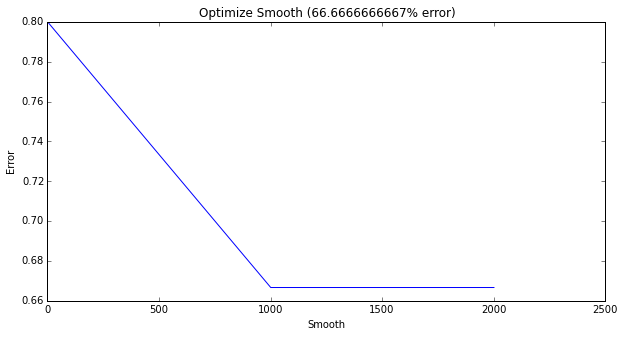

In [21]:
x=[]
y=[]
for i in range(1,3001,1000):
    x.append(i)
    y.append(classify(df_train, df_train, i))

plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.xlabel('Smooth')
plt.ylabel('Error')
plt.title('Optimize Smooth ('+str(min(y)*100)+'% error)')

We see that smoothing is optmium after 1000. 

Hence, we will train our classifier with the training data and test it on the test data with smoothing of 2000:

With smoothing of 2000, we see that we still have a 66.67% error. 

Let us analyze the flowers we failed to classify.

In [44]:
def find_error(sample_df, valid_df, smooth):

    #Empty list for probabilities
    prob = []

    #Find probability of each classifier
    for label in range(3): 
        cond = sample_df['class']==classes[label]
        mean = np.mean(sample_df.ix[:,0:4].values, axis = 0)
        cov = np.cov(np.transpose(sample_df[cond].ix[:,0:4].values)) + (smooth*np.identity(4))
        func = multivariate_normal(mean, cov)
        prob.append(func.logpdf(valid_df.ix[:,0:4]))

    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)

    #Compare with valid target to get error
    error = np.sum([classes[i]!=j for i,j in zip(max_prob, valid_df['class'])])/len(valid_df)
    

    #Compare with valid target to get error
    label = []
    flower = []
    probability = []
    prob = np.matrix(prob)
    for i,j,k in zip(max_prob, valid_df['class'], range(len(valid_df))):
        if  classes[i]!=j:
            flower.append(j)
            label.append(classes[i])
            probability.append(prob[:,k])
    return [flower, label, probability]

In [93]:
[flower, label, probability] = find_error(df_train, df_train, 2000)

In [94]:
error_dict = {}
error_dict['prediction'] = label
error_dict['flower'] = flower


error_df1 = pd.DataFrame(error_dict)
error_df1.head()

,flower,prediction
0,Iris-versicolor,Iris-setosa
1,Iris-versicolor,Iris-setosa
2,Iris-versicolor,Iris-setosa
3,Iris-versicolor,Iris-setosa
4,Iris-versicolor,Iris-setosa


We see that all the predictions provide Iris-setosa.

Let's look at the probabilities of the first 5 predictions.

In [70]:
error_df2 = pd.DataFrame(probability[0])
for i in range(1,5):
    error_df2[i] = probability[i]
error_df2.columns = range(0,5)
error_df2.index=classes
error_df2

,0,1,2,3,4
Iris-setosa,-18.877833,-18.878026,-18.877914,-18.877684,-18.877766
Iris-versicolor,-18.877919,-18.878112,-18.878000,-18.877770,-18.877852
Iris-virginica,-18.878017,-18.878210,-18.878098,-18.877868,-18.877950


We see that all 3 probabilities are really close and Iris-setosa has the highest probabilities.

This contradicts our PCA 2D scatter plot. Hence, there is some overfitting invovled.

Next, we will try to reduce the number of dimensions using PCA decomposition.


We can have 99%+ accuracy with K=2


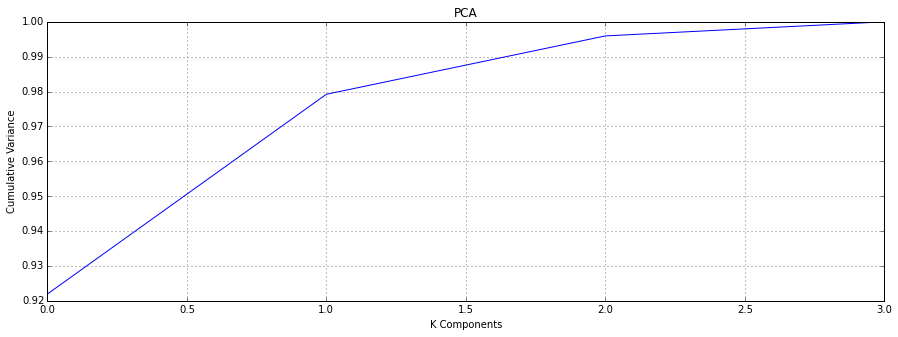

In [77]:
pca = PCA()
x = pca.fit(df_train.ix[:,0:4])
T = pca.transform(df_train.ix[:,0:4])
cumulative_explained = np.cumsum(pca.explained_variance_ratio_) 
plt.figure(figsize=(15,5))
plt.plot(cumulative_explained)
plt.xlabel('K Components')
plt.ylabel('Cumulative Variance')
plt.title('PCA')
plt.grid()
print('\nWe can have 99%+ accuracy with K=2')

Now, we will construct a new classifier with PCA decomposition at K=2

$$X \sim N_{4}(\mu,\Sigma) \rightarrow  N_{2}(\mu,\Sigma)$$

In [85]:
def classify_pca(sample_df, valid_df, smooth):

    #Empty list for probabilities
    prob = []

    #Find probability of each classifier
    for label in range(3): 
        cond = sample_df['class']==classes[label]
        mean = np.mean(sample_df.ix[:,5::].values, axis = 0)
        cov = np.cov(np.transpose(sample_df[cond].ix[:,5::].values)) + (smooth*np.identity(2))
        func = multivariate_normal(mean, cov)
        prob.append(func.logpdf(valid_df.ix[:,5::]))

    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)

    #Compare with valid target to get error
    error = np.sum([classes[i]!=j for i,j in zip(max_prob, valid_df['class'])])/len(valid_df)
    return error

Optimizing smoothing

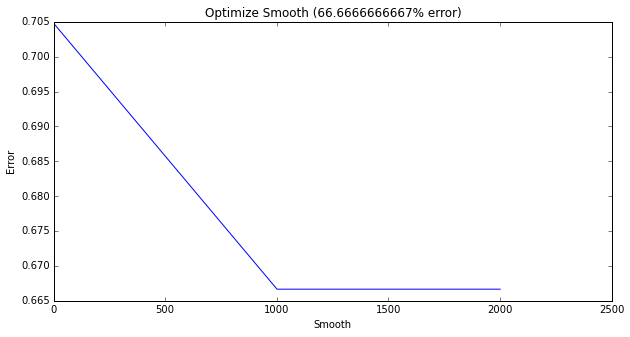

In [89]:
x=[]
y=[]
for i in range(1,3001,1000):
    x.append(i)
    y.append(classify_pca(df_train, df_train, i))

plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.xlabel('Smooth')
plt.ylabel('Error')
plt.title('Optimize Smooth ('+str(min(y)*100)+'% error)')

It seems that PCA decomposition of K=2 is not having a significant effect.

Let us analyze the error.

In [96]:
def find_error_PCA(sample_df, valid_df, smooth):

    #Empty list for probabilities
    prob = []

    #Find probability of each classifier
    for label in range(3): 
        cond = sample_df['class']==classes[label]
        mean = np.mean(sample_df.ix[:,5::].values, axis = 0)
        cov = np.cov(np.transpose(sample_df[cond].ix[:,5::].values)) + (smooth*np.identity(2))
        func = multivariate_normal(mean, cov)
        prob.append(func.logpdf(valid_df.ix[:,5::]))

    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)

    #Compare with valid target to get error
    error = np.sum([classes[i]!=j for i,j in zip(max_prob, valid_df['class'])])/len(valid_df)
    

    #Compare with valid target to get error
    label = []
    flower = []
    probability = []
    prob = np.matrix(prob)
    for i,j,k in zip(max_prob, valid_df['class'], range(len(valid_df))):
        if  classes[i]!=j:
            flower.append(j)
            label.append(classes[i])
            probability.append(prob[:,k])
    return [flower, label, probability]

In [97]:
[flower, label, probability] = find_error_PCA(df_train, df_train, 2000)

In [98]:
error_dict = {}
error_dict['prediction'] = label
error_dict['flower'] = flower


error_df1 = pd.DataFrame(error_dict)
error_df1.head()

,flower,prediction
0,Iris-versicolor,Iris-setosa
1,Iris-versicolor,Iris-setosa
2,Iris-versicolor,Iris-setosa
3,Iris-versicolor,Iris-setosa
4,Iris-versicolor,Iris-setosa


We see that all the predictions provide Iris-setosa.

Let's look at the probabilities of the first 5 predictions.

In [99]:
error_df2 = pd.DataFrame(probability[0])
for i in range(1,5):
    error_df2[i] = probability[i]
error_df2.columns = range(0,5)
error_df2.index=classes
error_df2

,0,1,2,3,4
Iris-setosa,-9.439336,-9.439063,-9.439403,-9.439034,-9.439116
Iris-versicolor,-9.439409,-9.439136,-9.439476,-9.439107,-9.439190
Iris-virginica,-9.439491,-9.439218,-9.439558,-9.439189,-9.439271


Once again, we see that the probabilities are extremely close to eachother with iris-setosa getting the highest probabilities.